In [5]:
# 1. Necessary Imports
import os
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, Subset, WeightedRandomSampler
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import confusion_matrix, classification_report
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import cv2
from collections import Counter

# 2. Setup and Configuration
def setup():
    """Initializes device, paths, and class names."""
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    
    base_dir = 'colored_images'
    if not os.path.isdir(base_dir):
        raise FileNotFoundError(f"The directory '{base_dir}' was not found. Please ensure it exists.")
        
    class_names = sorted([d for d in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, d))])
    num_classes = len(class_names)
    print(f"Found {num_classes} classes: {class_names}")

    return device, base_dir, class_names, num_classes


# 3. Data Loading and Preprocessing

# Helper: Class-Balanced weights (effective number of samples)
def class_balanced_weights_from_labels(labels, num_classes, beta=0.9999):
    counts = np.bincount(labels, minlength=num_classes).astype(np.float64)
    effective_num = 1.0 - np.power(beta, counts)
    effective_num = np.where(effective_num > 0, effective_num, 1.0)
    weights = (1.0 - beta) / effective_num
    weights = weights / weights.mean()
    return torch.tensor(weights, dtype=torch.float32)

def get_dataloaders(base_dir, class_names):
    """Creates stratified data loaders with weighted sampling for imbalance."""
    
    # Training augmentation only; no aug on val/test; images are already 224x224
    data_transforms = {
        'train': transforms.Compose([
            transforms.RandomRotation(15, expand=False),  # keeps 224x224
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406],
                                 [0.229, 0.224, 0.225])
        ]),
        'val': transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406],
                                 [0.229, 0.224, 0.225])
        ])
    }

    # Load full dataset
    full_dataset = datasets.ImageFolder(base_dir)
    targets = full_dataset.targets

    # Stratified split (70/15/15)
    sss_train_valtest = StratifiedShuffleSplit(n_splits=1, test_size=0.30, random_state=42)
    train_indices, val_test_indices = next(sss_train_valtest.split(np.zeros(len(targets)), targets))
    val_test_targets = np.array(targets)[val_test_indices]
    sss_val_test = StratifiedShuffleSplit(n_splits=1, test_size=0.50, random_state=42)
    val_sub_indices, test_sub_indices = next(sss_val_test.split(np.zeros(len(val_test_targets)), val_test_targets))
    val_indices = val_test_indices[val_sub_indices]
    test_indices = val_test_indices[test_sub_indices]

    # Create subsets
    train_dataset = Subset(datasets.ImageFolder(base_dir, transform=data_transforms['train']), train_indices)
    val_dataset = Subset(datasets.ImageFolder(base_dir, transform=data_transforms['val']), val_indices)
    test_dataset = Subset(datasets.ImageFolder(base_dir, transform=data_transforms['val']), test_indices)

    print(f"Dataset split: {len(train_dataset)} train, {len(val_dataset)} validation, {len(test_dataset)} test images.")

    # ---- HANDLE CLASS IMBALANCE ----
    train_labels = [full_dataset.targets[i] for i in train_indices]
    class_counts = Counter(train_labels)
    print(f"Training class distribution: {dict(class_counts)}")

    cb_weights = class_balanced_weights_from_labels(train_labels, num_classes=len(class_names), beta=0.9999)
    sample_weights = [cb_weights[label].item() for label in train_labels]
    sampler = WeightedRandomSampler(weights=sample_weights,
                                    num_samples=len(sample_weights),
                                    replacement=True)

    # Create dataloaders (pin_memory only if CUDA)
    pin = torch.cuda.is_available()
    dataloaders = {
        'train': DataLoader(train_dataset, batch_size=32, sampler=sampler, num_workers=2, pin_memory=pin),
        'val': DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2, pin_memory=pin),
        'test': DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2, pin_memory=pin),
        'cb_class_weights': cb_weights
    }

    return dataloaders


# 4. Model Training and Evaluation

# Depthwise kernel-size replacement to try different convolutions
def _is_depthwise_conv(mod: nn.Module):
    return isinstance(mod, nn.Conv2d) and mod.groups == mod.in_channels and mod.out_channels == mod.in_channels

def _replace_dwconv(module: nn.Module, k: int, dilation: int = 1):
    padding = ((k - 1) // 2) * dilation
    for name, child in module.named_children():
        if _is_depthwise_conv(child):
            new = nn.Conv2d(
                child.in_channels,
                child.out_channels,
                kernel_size=k,
                stride=child.stride,
                padding=padding,
                dilation=dilation,
                groups=child.groups,
                bias=(child.bias is not None),
            )
            nn.init.kaiming_normal_(new.weight, mode='fan_out', nonlinearity='relu')
            if new.bias is not None:
                nn.init.zeros_(new.bias)
            setattr(module, name, new)
        else:
            _replace_dwconv(child, k, dilation)

def build_convnext_tiny_with_dw(num_classes: int, dw_kernel_size: int = 7, dilation: int = 1, pretrained: bool = True):
    weights = models.ConvNeXt_Tiny_Weights.IMAGENET1K_V1 if pretrained else None
    model = models.convnext_tiny(weights=weights)
    _replace_dwconv(model.features, k=dw_kernel_size, dilation=dilation)
    model.classifier[2] = nn.Linear(model.classifier[2].in_features, num_classes)
    return model

def train_model(model, dataloaders, criterion, optimizer, device, num_epochs, class_names):
    """Trains the model with early stopping."""
    best_val_loss = float('inf')
    epochs_no_improve = 0
    patience = 7

    for epoch in range(num_epochs):
        print(f'\nEpoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        model.train()
        running_loss = 0.0
        running_corrects = 0
        total_samples = 0

        progress_bar = tqdm(dataloaders['train'], desc="Training")
        for inputs, labels in progress_bar:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)

            preds = outputs.argmax(dim=1)
            running_corrects += (preds == labels).sum().item()
            total_samples += labels.size(0)

            progress_bar.set_postfix({'loss': f'{loss.item():.4f}'})

        epoch_loss = running_loss / total_samples
        epoch_train_acc = running_corrects / total_samples

        val_loss, val_acc, _ = evaluate_model(model, dataloaders['val'], criterion, device, class_names)

        print(f'Train Loss: {epoch_loss:.4f} | Train Acc: {epoch_train_acc:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}')

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_no_improve = 0
            torch.save(model.state_dict(), 'best_convnext_model.pth')
            print("Validation loss improved. Saving model.")
        else:
            epochs_no_improve += 1
            print(f"No improvement in validation loss for {epochs_no_improve} epoch(s).")

        if epochs_no_improve >= patience:
            print("Early stopping triggered.")
            break

    print("Training complete.")
    model.load_state_dict(torch.load('best_convnext_model.pth'))
    return model


def evaluate_model(model, dataloader, criterion, device, class_names, is_test=False):
    model.eval()
    running_loss = 0.0
    all_preds, all_labels = [], []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc = np.mean(np.array(all_labels) == np.array(all_preds))
    report_dict = {'true_labels': all_labels, 'pred_labels': all_preds}

    if is_test:
        cm = confusion_matrix(all_labels, all_preds)
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
        plt.title('Confusion Matrix')
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.show()

        # Extended metrics: per-class accuracy + macro/micro accuracy
        per_class_acc = np.divide(np.diag(cm), cm.sum(axis=1).clip(min=1))
        macro_acc = per_class_acc.mean()
        micro_acc = np.trace(cm) / cm.sum().clip(min=1)

        print("\nPer-class accuracy:")
        for idx, name in enumerate(class_names):
            print(f"{name}: {per_class_acc[idx]:.4f}")
        print(f"\nMacro Accuracy: {macro_acc:.4f}")
        print(f"Micro Accuracy (Overall): {micro_acc:.4f}")

    return epoch_loss, epoch_acc, report_dict


# 5. Grad-CAM (same as before)
class GradCAM:
    def _init_(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        target_layer.register_forward_hook(self.save_activation)
        target_layer.register_full_backward_hook(self.save_gradient)

    def save_activation(self, module, input, output):
        self.activations = output.detach()

    def save_gradient(self, module, grad_input, grad_output):
        self.gradients = grad_output[0].detach()

    def _call_(self, x, class_idx=None):
        self.model.eval()
        output = self.model(x)
        if class_idx is None:
            class_idx = output.argmax(dim=1).item()
        one_hot = torch.zeros_like(output)
        one_hot[0][class_idx] = 1
        self.model.zero_grad()
        output.backward(gradient=one_hot, retain_graph=True)
        pooled_gradients = torch.mean(self.gradients, dim=[0, 2, 3])
        activ = self.activations.clone()
        for i in range(activ.shape[1]):
            activ[:, i, :, :] *= pooled_gradients[i]
        heatmap = torch.mean(activ, dim=1).squeeze()
        heatmap = torch.clamp(heatmap, min=0)
        heatmap = heatmap / (heatmap.max() + 1e-8)
        return heatmap.cpu().numpy()


def visualize_cam(model, device, base_dir, class_names):
    output_dir = 'ConvNeXt_CAM'
    os.makedirs(output_dir, exist_ok=True)

    target_layer = model.features[-1]  # for ConvNeXt
    grad_cam = GradCAM(model, target_layer)

    vis_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])

    for class_name in class_names:
        class_dir = os.path.join(base_dir, class_name)
        img_name = random.choice(os.listdir(class_dir))
        img_path = os.path.join(class_dir, img_name)

        img = Image.open(img_path).convert('RGB')
        input_tensor = vis_transform(img).unsqueeze(0).to(device)

        heatmap = grad_cam(input_tensor)

        img_cv = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)  # assumes 224x224 inputs
        heatmap_resized = cv2.resize(heatmap, (img_cv.shape[1], img_cv.shape[0]))
        heatmap_color = cv2.applyColorMap(np.uint8(255 * heatmap_resized), cv2.COLORMAP_JET)
        superimposed_img = cv2.addWeighted(img_cv, 0.6, heatmap_color, 0.4, 0)

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
        ax1.imshow(cv2.cvtColor(img_cv, cv2.COLOR_BGR2RGB))
        ax1.set_title(f'Original: {class_name}')
        ax1.axis('off')

        ax2.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
        ax2.set_title(f'Grad-CAM: {class_name}')
        ax2.axis('off')

        plt.tight_layout()
        save_path = os.path.join(output_dir, f'cam_{class_name}.png')
        plt.savefig(save_path)
        plt.show()
        print(f"Saved Grad-CAM for {class_name} to {save_path}")


# 6. Main Execution Block
if __name__ == '__main__':
    device, base_dir, class_names, num_classes = setup()
    dataloaders = get_dataloaders(base_dir, class_names)

    # Load ConvNeXt-Tiny with different DW kernels and sweep
    kernel_sizes = [3, 5, 7, 9, 11]
    results = []

    for k in kernel_sizes:
        print(f"\n===== Testing ConvNeXt-Tiny with DW kernel size = {k} =====")
        model = build_convnext_tiny_with_dw(num_classes=num_classes, dw_kernel_size=k, dilation=1, pretrained=True)
        model = model.to(device)

        weights = dataloaders['cb_class_weights'].to(device)
        criterion = nn.CrossEntropyLoss(weight=weights)
        optimizer = optim.Adam(model.parameters(), lr=1e-4)

        trained_model = train_model(model, dataloaders, criterion, optimizer, device, num_epochs=8, class_names=class_names)

        print("\n--- Validation Snapshot ---")
        val_loss, val_acc, _ = evaluate_model(trained_model, dataloaders['val'], criterion, device, class_names, is_test=False)
        results.append((k, val_acc))

    print("\nKernel size vs Val Acc:")
    for k, acc in results:
        print(f"k={k}: {acc:.4f}")

    best_k = max(results, key=lambda x: x[1])[0]
    print(f"\nBest kernel size by Val Acc: {best_k}")
    model = build_convnext_tiny_with_dw(num_classes=num_classes, dw_kernel_size=best_k, dilation=1, pretrained=True)
    model = model.to(device)

    weights = dataloaders['cb_class_weights'].to(device)
    criterion = nn.CrossEntropyLoss(weight=weights)
    optimizer = optim.Adam(model.parameters(), lr=1e-4)
    trained_model = train_model(model, dataloaders, criterion, optimizer, device, num_epochs=25, class_names=class_names)

    print("\n--- Final Evaluation on Test Set ---")
    test_loss, test_acc, test_report_dict = evaluate_model(trained_model, dataloaders['test'], criterion, device, class_names, is_test=True)
    print(f"\nTest Loss: {test_loss:.4f}")
    print(f"Test Accuracy: {test_acc:.4f}")
    print("\nFinal Test Classification Report:")
    print(classification_report(test_report_dict['true_labels'], test_report_dict['pred_labels'], target_names=class_names, digits=4, zero_division=0))

    print("\n--- Generating Grad-CAM Visualizations ---")
    visualize_cam(trained_model, device, base_dir, class_names)

Using device: cuda
Found 5 classes: ['Mild', 'Moderate', 'No_DR', 'Proliferate_DR', 'Severe']
Dataset split: 2563 train, 549 validation, 550 test images.
Training class distribution: {3: 207, 2: 1263, 1: 699, 4: 135, 0: 259}

===== Testing ConvNeXt-Tiny with DW kernel size = 3 =====


Downloading: "https://download.pytorch.org/models/convnext_tiny-983f1562.pth" to C:\Users\Sahil/.cache\torch\hub\checkpoints\convnext_tiny-983f1562.pth
100%|██████████| 109M/109M [00:04<00:00, 28.2MB/s] 



Epoch 1/8
----------


Training: 100%|██████████| 81/81 [00:32<00:00,  2.47it/s, loss=1.1369]


Train Loss: 1.4133 | Train Acc: 0.2052 | Val Loss: 1.9109 | Val Acc: 0.0510
Validation loss improved. Saving model.

Epoch 2/8
----------


Training:  11%|█         | 9/81 [00:21<02:55,  2.43s/it, loss=1.3167]


KeyboardInterrupt: 

In [6]:
import torch
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0))
print(next(model.parameters()).device)


True
NVIDIA GeForce RTX 4060 Laptop GPU
cuda:0


Using device: cuda
Found 5 classes: ['Mild', 'Moderate', 'No_DR', 'Proliferate_DR', 'Severe']

✅ CUDA is available. Using GPU: NVIDIA GeForce RTX 4060 Laptop GPU
Memory Allocated: 460.55 MB
Memory Cached: 4162.00 MB
Dataset split: 2563 train, 549 validation, 550 test images.
Training class distribution: {3: 207, 2: 1263, 1: 699, 4: 135, 0: 259}

===== Testing ConvNeXt-Tiny with DW kernel size = 3 =====
⚙️ Training on device: cuda:0

Epoch 1/8
----------


Training: 100%|██████████| 81/81 [01:09<00:00,  1.17it/s, loss=1.3744, GPU_mem_MB=891.1]


Train Loss: 1.4218 | Train Acc: 0.2033 | Val Loss: 1.8670 | Val Acc: 0.0510
Validation loss improved. Saving model.

Epoch 2/8
----------


Training: 100%|██████████| 81/81 [01:12<00:00,  1.12it/s, loss=2.1587, GPU_mem_MB=891.1]


Train Loss: 1.3907 | Train Acc: 0.2236 | Val Loss: 1.7903 | Val Acc: 0.0801
Validation loss improved. Saving model.

Epoch 3/8
----------


Training: 100%|██████████| 81/81 [01:11<00:00,  1.13it/s, loss=1.1302, GPU_mem_MB=891.1]


Train Loss: 1.3551 | Train Acc: 0.2400 | Val Loss: 1.7872 | Val Acc: 0.0947
Validation loss improved. Saving model.

Epoch 4/8
----------


Training: 100%|██████████| 81/81 [01:04<00:00,  1.25it/s, loss=1.8518, GPU_mem_MB=891.1]


Train Loss: 1.3216 | Train Acc: 0.2618 | Val Loss: 1.5780 | Val Acc: 0.2295
Validation loss improved. Saving model.

Epoch 5/8
----------


Training: 100%|██████████| 81/81 [01:10<00:00,  1.14it/s, loss=1.0084, GPU_mem_MB=891.1]


Train Loss: 1.2759 | Train Acc: 0.3457 | Val Loss: 1.4094 | Val Acc: 0.4736
Validation loss improved. Saving model.

Epoch 6/8
----------


Training: 100%|██████████| 81/81 [01:10<00:00,  1.15it/s, loss=1.3510, GPU_mem_MB=891.1]


Train Loss: 1.2409 | Train Acc: 0.3750 | Val Loss: 1.3515 | Val Acc: 0.4900
Validation loss improved. Saving model.

Epoch 7/8
----------


Training: 100%|██████████| 81/81 [01:09<00:00,  1.16it/s, loss=1.8940, GPU_mem_MB=891.1]


Train Loss: 1.1875 | Train Acc: 0.3921 | Val Loss: 1.3383 | Val Acc: 0.5264
Validation loss improved. Saving model.

Epoch 8/8
----------


Training: 100%|██████████| 81/81 [01:11<00:00,  1.14it/s, loss=1.7008, GPU_mem_MB=891.1]


Train Loss: 1.2057 | Train Acc: 0.3999 | Val Loss: 1.4705 | Val Acc: 0.2568
No improvement in validation loss for 1 epoch(s).
Training complete.


C:\Users\Sahil\AppData\Local\Temp\ipykernel_37704\1669697388.py:198: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_convnext_model.pth'


--- Validation Snapshot ---

===== Testing ConvNeXt-Tiny with DW kernel size = 5 =====
⚙️ Training on device: cuda:0

Epoch 1/8
----------


Training: 100%|██████████| 81/81 [01:11<00:00,  1.14it/s, loss=1.9415, GPU_mem_MB=1110.5]


Train Loss: 1.4138 | Train Acc: 0.2002 | Val Loss: 1.8509 | Val Acc: 0.0874
Validation loss improved. Saving model.

Epoch 2/8
----------


Training: 100%|██████████| 81/81 [01:11<00:00,  1.13it/s, loss=2.1260, GPU_mem_MB=1110.5]


Train Loss: 1.3724 | Train Acc: 0.2364 | Val Loss: 1.8736 | Val Acc: 0.0874
No improvement in validation loss for 1 epoch(s).

Epoch 3/8
----------


Training: 100%|██████████| 81/81 [01:11<00:00,  1.13it/s, loss=1.7389, GPU_mem_MB=1110.5]


Train Loss: 1.3674 | Train Acc: 0.2357 | Val Loss: 1.8463 | Val Acc: 0.0601
Validation loss improved. Saving model.

Epoch 4/8
----------


Training: 100%|██████████| 81/81 [01:12<00:00,  1.12it/s, loss=1.2800, GPU_mem_MB=1110.5]


Train Loss: 1.3212 | Train Acc: 0.2712 | Val Loss: 1.4585 | Val Acc: 0.4536
Validation loss improved. Saving model.

Epoch 5/8
----------


Training: 100%|██████████| 81/81 [01:11<00:00,  1.13it/s, loss=1.9862, GPU_mem_MB=1110.5]


Train Loss: 1.2481 | Train Acc: 0.3593 | Val Loss: 1.4402 | Val Acc: 0.4426
Validation loss improved. Saving model.

Epoch 6/8
----------


Training: 100%|██████████| 81/81 [01:11<00:00,  1.13it/s, loss=1.1110, GPU_mem_MB=1110.5]


Train Loss: 1.2421 | Train Acc: 0.3750 | Val Loss: 1.4747 | Val Acc: 0.2587
No improvement in validation loss for 1 epoch(s).

Epoch 7/8
----------


Training: 100%|██████████| 81/81 [01:11<00:00,  1.13it/s, loss=0.7687, GPU_mem_MB=1110.5]


Train Loss: 1.1923 | Train Acc: 0.3945 | Val Loss: 1.4416 | Val Acc: 0.2805
No improvement in validation loss for 2 epoch(s).

Epoch 8/8
----------


Training: 100%|██████████| 81/81 [01:11<00:00,  1.13it/s, loss=1.4183, GPU_mem_MB=1110.5]


Train Loss: 1.1912 | Train Acc: 0.4038 | Val Loss: 1.4855 | Val Acc: 0.3188
No improvement in validation loss for 3 epoch(s).
Training complete.

--- Validation Snapshot ---

===== Testing ConvNeXt-Tiny with DW kernel size = 7 =====
⚙️ Training on device: cuda:0

Epoch 1/8
----------


Training: 100%|██████████| 81/81 [01:33<00:00,  1.16s/it, loss=1.7162, GPU_mem_MB=1111.8]


Train Loss: 1.4316 | Train Acc: 0.1888 | Val Loss: 1.8671 | Val Acc: 0.0528
Validation loss improved. Saving model.

Epoch 2/8
----------


Training: 100%|██████████| 81/81 [01:33<00:00,  1.16s/it, loss=1.7707, GPU_mem_MB=1111.8]


Train Loss: 1.3994 | Train Acc: 0.2091 | Val Loss: 1.9271 | Val Acc: 0.0546
No improvement in validation loss for 1 epoch(s).

Epoch 3/8
----------


Training: 100%|██████████| 81/81 [01:35<00:00,  1.18s/it, loss=2.2868, GPU_mem_MB=1111.8]


Train Loss: 1.3598 | Train Acc: 0.2403 | Val Loss: 1.6692 | Val Acc: 0.2750
Validation loss improved. Saving model.

Epoch 4/8
----------


Training: 100%|██████████| 81/81 [01:35<00:00,  1.18s/it, loss=1.3764, GPU_mem_MB=1111.8]


Train Loss: 1.3407 | Train Acc: 0.2501 | Val Loss: 1.6971 | Val Acc: 0.1075
No improvement in validation loss for 1 epoch(s).

Epoch 5/8
----------


Training: 100%|██████████| 81/81 [01:36<00:00,  1.19s/it, loss=1.0981, GPU_mem_MB=1111.8]


Train Loss: 1.2537 | Train Acc: 0.3203 | Val Loss: 1.4519 | Val Acc: 0.3406
Validation loss improved. Saving model.

Epoch 6/8
----------


Training: 100%|██████████| 81/81 [01:36<00:00,  1.19s/it, loss=1.5218, GPU_mem_MB=1111.8]


Train Loss: 1.2450 | Train Acc: 0.3554 | Val Loss: 1.6699 | Val Acc: 0.2714
No improvement in validation loss for 1 epoch(s).

Epoch 7/8
----------


Training: 100%|██████████| 81/81 [01:35<00:00,  1.18s/it, loss=0.6114, GPU_mem_MB=1111.8]


Train Loss: 1.1978 | Train Acc: 0.3937 | Val Loss: 1.3837 | Val Acc: 0.4736
Validation loss improved. Saving model.

Epoch 8/8
----------


Training: 100%|██████████| 81/81 [01:36<00:00,  1.19s/it, loss=1.0681, GPU_mem_MB=1111.8] 


Train Loss: 1.2157 | Train Acc: 0.4038 | Val Loss: 1.4438 | Val Acc: 0.2787
No improvement in validation loss for 1 epoch(s).
Training complete.

--- Validation Snapshot ---

===== Testing ConvNeXt-Tiny with DW kernel size = 9 =====
⚙️ Training on device: cuda:0

Epoch 1/8
----------


Training: 100%|██████████| 81/81 [02:17<00:00,  1.70s/it, loss=1.4437, GPU_mem_MB=1117.2]


Train Loss: 1.4370 | Train Acc: 0.1974 | Val Loss: 1.7984 | Val Acc: 0.0965
Validation loss improved. Saving model.

Epoch 2/8
----------


Training: 100%|██████████| 81/81 [02:19<00:00,  1.72s/it, loss=1.7990, GPU_mem_MB=1117.2]


Train Loss: 1.3860 | Train Acc: 0.2123 | Val Loss: 1.7573 | Val Acc: 0.1038
Validation loss improved. Saving model.

Epoch 3/8
----------


Training: 100%|██████████| 81/81 [02:16<00:00,  1.69s/it, loss=1.0460, GPU_mem_MB=1117.2]


Train Loss: 1.3459 | Train Acc: 0.2380 | Val Loss: 2.0053 | Val Acc: 0.0528
No improvement in validation loss for 1 epoch(s).

Epoch 4/8
----------


Training: 100%|██████████| 81/81 [02:15<00:00,  1.68s/it, loss=1.3520, GPU_mem_MB=1117.2]


Train Loss: 1.3119 | Train Acc: 0.2786 | Val Loss: 1.7173 | Val Acc: 0.2568
Validation loss improved. Saving model.

Epoch 5/8
----------


Training: 100%|██████████| 81/81 [02:16<00:00,  1.68s/it, loss=1.0228, GPU_mem_MB=1117.2]


Train Loss: 1.2868 | Train Acc: 0.3047 | Val Loss: 1.5805 | Val Acc: 0.1985
Validation loss improved. Saving model.

Epoch 6/8
----------


Training: 100%|██████████| 81/81 [02:15<00:00,  1.68s/it, loss=0.7562, GPU_mem_MB=1117.2]


Train Loss: 1.2344 | Train Acc: 0.3234 | Val Loss: 1.4209 | Val Acc: 0.4317
Validation loss improved. Saving model.

Epoch 7/8
----------


Training: 100%|██████████| 81/81 [02:15<00:00,  1.67s/it, loss=1.9593, GPU_mem_MB=1117.2]


Train Loss: 1.2388 | Train Acc: 0.3547 | Val Loss: 1.4296 | Val Acc: 0.4244
No improvement in validation loss for 1 epoch(s).

Epoch 8/8
----------


Training: 100%|██████████| 81/81 [02:16<00:00,  1.69s/it, loss=1.3224, GPU_mem_MB=1117.2]


Train Loss: 1.1878 | Train Acc: 0.3882 | Val Loss: 1.4234 | Val Acc: 0.3716
No improvement in validation loss for 2 epoch(s).
Training complete.

--- Validation Snapshot ---

===== Testing ConvNeXt-Tiny with DW kernel size = 11 =====
⚙️ Training on device: cuda:0

Epoch 1/8
----------


Training: 100%|██████████| 81/81 [02:44<00:00,  2.03s/it, loss=1.1983, GPU_mem_MB=1121.4]


Train Loss: 1.4098 | Train Acc: 0.2005 | Val Loss: 1.9366 | Val Acc: 0.0528
Validation loss improved. Saving model.

Epoch 2/8
----------


Training: 100%|██████████| 81/81 [02:44<00:00,  2.03s/it, loss=2.5940, GPU_mem_MB=1121.4]


Train Loss: 1.3936 | Train Acc: 0.2080 | Val Loss: 1.8579 | Val Acc: 0.0528
Validation loss improved. Saving model.

Epoch 3/8
----------


Training: 100%|██████████| 81/81 [02:44<00:00,  2.04s/it, loss=1.7490, GPU_mem_MB=1121.4]


Train Loss: 1.3634 | Train Acc: 0.2540 | Val Loss: 1.7026 | Val Acc: 0.1949
Validation loss improved. Saving model.

Epoch 4/8
----------


Training: 100%|██████████| 81/81 [02:44<00:00,  2.04s/it, loss=1.2693, GPU_mem_MB=1121.4]


Train Loss: 1.3674 | Train Acc: 0.2353 | Val Loss: 1.8077 | Val Acc: 0.1002
No improvement in validation loss for 1 epoch(s).

Epoch 5/8
----------


Training: 100%|██████████| 81/81 [02:42<00:00,  2.01s/it, loss=2.2998, GPU_mem_MB=1121.4]


Train Loss: 1.3409 | Train Acc: 0.2688 | Val Loss: 1.5665 | Val Acc: 0.2587
Validation loss improved. Saving model.

Epoch 6/8
----------


Training: 100%|██████████| 81/81 [02:51<00:00,  2.12s/it, loss=0.8708, GPU_mem_MB=1121.4] 


Train Loss: 1.2871 | Train Acc: 0.2918 | Val Loss: 1.6000 | Val Acc: 0.2350
No improvement in validation loss for 1 epoch(s).

Epoch 7/8
----------


Training: 100%|██████████| 81/81 [02:48<00:00,  2.08s/it, loss=1.7627, GPU_mem_MB=1121.4]


Train Loss: 1.2616 | Train Acc: 0.3352 | Val Loss: 1.5630 | Val Acc: 0.4007
Validation loss improved. Saving model.

Epoch 8/8
----------


Training: 100%|██████████| 81/81 [02:49<00:00,  2.09s/it, loss=1.4293, GPU_mem_MB=1121.4] 


Train Loss: 1.2153 | Train Acc: 0.3792 | Val Loss: 1.4612 | Val Acc: 0.3898
Validation loss improved. Saving model.
Training complete.

--- Validation Snapshot ---

Kernel size vs Val Acc:
k=3: 0.5264
k=5: 0.4426
k=7: 0.4736
k=9: 0.4317
k=11: 0.3898

Best kernel size by Val Acc: 3
⚙️ Training on device: cuda:0

Epoch 1/25
----------


Training: 100%|██████████| 81/81 [01:10<00:00,  1.15it/s, loss=1.6517, GPU_mem_MB=1112.3]


Train Loss: 1.3981 | Train Acc: 0.2251 | Val Loss: 1.7943 | Val Acc: 0.1056
Validation loss improved. Saving model.

Epoch 2/25
----------


Training: 100%|██████████| 81/81 [01:11<00:00,  1.13it/s, loss=1.5279, GPU_mem_MB=1112.3]


Train Loss: 1.3752 | Train Acc: 0.2282 | Val Loss: 1.8895 | Val Acc: 0.1075
No improvement in validation loss for 1 epoch(s).

Epoch 3/25
----------


Training: 100%|██████████| 81/81 [01:13<00:00,  1.11it/s, loss=0.5597, GPU_mem_MB=1112.3] 


Train Loss: 1.3507 | Train Acc: 0.2520 | Val Loss: 1.8890 | Val Acc: 0.1056
No improvement in validation loss for 2 epoch(s).

Epoch 4/25
----------


Training: 100%|██████████| 81/81 [01:09<00:00,  1.16it/s, loss=1.4188, GPU_mem_MB=1112.3]


Train Loss: 1.3500 | Train Acc: 0.2446 | Val Loss: 1.6039 | Val Acc: 0.0947
Validation loss improved. Saving model.

Epoch 5/25
----------


Training: 100%|██████████| 81/81 [01:08<00:00,  1.18it/s, loss=1.6541, GPU_mem_MB=1112.3]


Train Loss: 1.3008 | Train Acc: 0.2938 | Val Loss: 1.5157 | Val Acc: 0.4262
Validation loss improved. Saving model.

Epoch 6/25
----------


Training: 100%|██████████| 81/81 [01:11<00:00,  1.13it/s, loss=1.5680, GPU_mem_MB=1112.3]


Train Loss: 1.2489 | Train Acc: 0.3660 | Val Loss: 1.3710 | Val Acc: 0.4517
Validation loss improved. Saving model.

Epoch 7/25
----------


Training: 100%|██████████| 81/81 [01:10<00:00,  1.15it/s, loss=1.6083, GPU_mem_MB=1112.3]


Train Loss: 1.2373 | Train Acc: 0.3769 | Val Loss: 1.4253 | Val Acc: 0.4572
No improvement in validation loss for 1 epoch(s).

Epoch 8/25
----------


Training: 100%|██████████| 81/81 [01:10<00:00,  1.15it/s, loss=1.2517, GPU_mem_MB=1112.3]


Train Loss: 1.1870 | Train Acc: 0.4276 | Val Loss: 1.3640 | Val Acc: 0.4827
Validation loss improved. Saving model.

Epoch 9/25
----------


Training: 100%|██████████| 81/81 [01:09<00:00,  1.16it/s, loss=0.9819, GPU_mem_MB=1112.3]


Train Loss: 1.2075 | Train Acc: 0.3859 | Val Loss: 1.3014 | Val Acc: 0.5046
Validation loss improved. Saving model.

Epoch 10/25
----------


Training: 100%|██████████| 81/81 [01:10<00:00,  1.15it/s, loss=1.5907, GPU_mem_MB=1112.3]


Train Loss: 1.1625 | Train Acc: 0.4339 | Val Loss: 1.5526 | Val Acc: 0.4080
No improvement in validation loss for 1 epoch(s).

Epoch 11/25
----------


Training: 100%|██████████| 81/81 [01:10<00:00,  1.15it/s, loss=1.2571, GPU_mem_MB=1112.3]


Train Loss: 1.1749 | Train Acc: 0.4171 | Val Loss: 1.5921 | Val Acc: 0.4827
No improvement in validation loss for 2 epoch(s).

Epoch 12/25
----------


Training: 100%|██████████| 81/81 [01:09<00:00,  1.16it/s, loss=0.6377, GPU_mem_MB=1112.3]


Train Loss: 1.1757 | Train Acc: 0.4362 | Val Loss: 1.3857 | Val Acc: 0.4900
No improvement in validation loss for 3 epoch(s).

Epoch 13/25
----------


Training: 100%|██████████| 81/81 [01:09<00:00,  1.17it/s, loss=1.6672, GPU_mem_MB=1112.3]


Train Loss: 1.1514 | Train Acc: 0.4210 | Val Loss: 1.3290 | Val Acc: 0.4754
No improvement in validation loss for 4 epoch(s).

Epoch 14/25
----------


Training: 100%|██████████| 81/81 [01:08<00:00,  1.18it/s, loss=0.6399, GPU_mem_MB=1112.3]


Train Loss: 1.1160 | Train Acc: 0.4596 | Val Loss: 1.3552 | Val Acc: 0.4809
No improvement in validation loss for 5 epoch(s).

Epoch 15/25
----------


Training: 100%|██████████| 81/81 [01:10<00:00,  1.15it/s, loss=2.6774, GPU_mem_MB=1112.3]


Train Loss: 1.0818 | Train Acc: 0.4674 | Val Loss: 1.3514 | Val Acc: 0.3497
No improvement in validation loss for 6 epoch(s).

Epoch 16/25
----------


Training: 100%|██████████| 81/81 [01:08<00:00,  1.18it/s, loss=1.0160, GPU_mem_MB=1112.3]


Train Loss: 1.0930 | Train Acc: 0.4553 | Val Loss: 1.3533 | Val Acc: 0.4882
No improvement in validation loss for 7 epoch(s).
Early stopping triggered.
Training complete.

--- Final Evaluation on Test Set ---


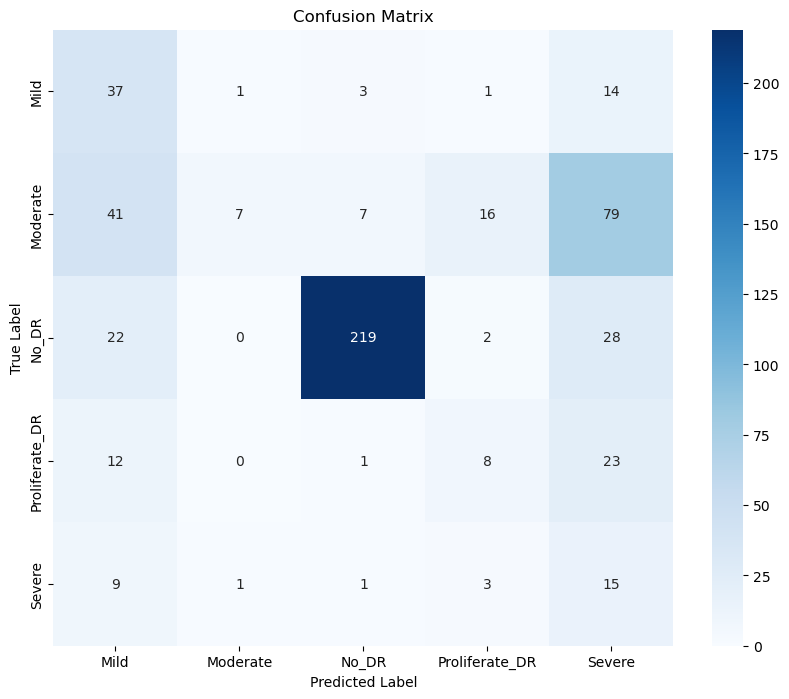


Per-class accuracy:
Mild: 0.6607
Moderate: 0.0467
No_DR: 0.8081
Proliferate_DR: 0.1818
Severe: 0.5172

Macro Accuracy: 0.4429
Micro Accuracy (Overall): 0.5200

Test Loss: 1.2870
Test Accuracy: 0.5200

Final Test Classification Report:
                precision    recall  f1-score   support

          Mild     0.3058    0.6607    0.4181        56
      Moderate     0.7778    0.0467    0.0881       150
         No_DR     0.9481    0.8081    0.8725       271
Proliferate_DR     0.2667    0.1818    0.2162        44
        Severe     0.0943    0.5172    0.1596        29

      accuracy                         0.5200       550
     macro avg     0.4785    0.4429    0.3509       550
  weighted avg     0.7367    0.5200    0.5222       550


--- Generating Grad-CAM Visualizations ---


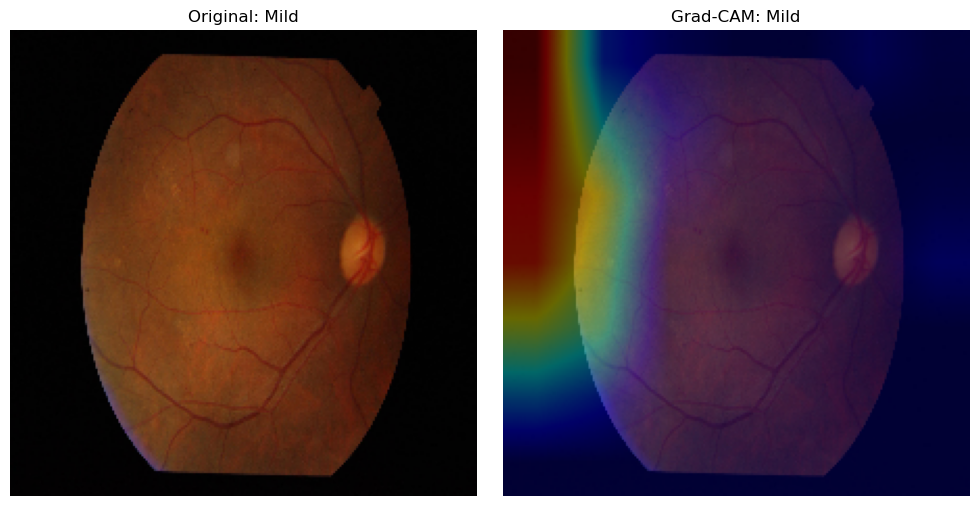

Saved Grad-CAM for Mild to ConvNeXt_CAM\cam_Mild.png


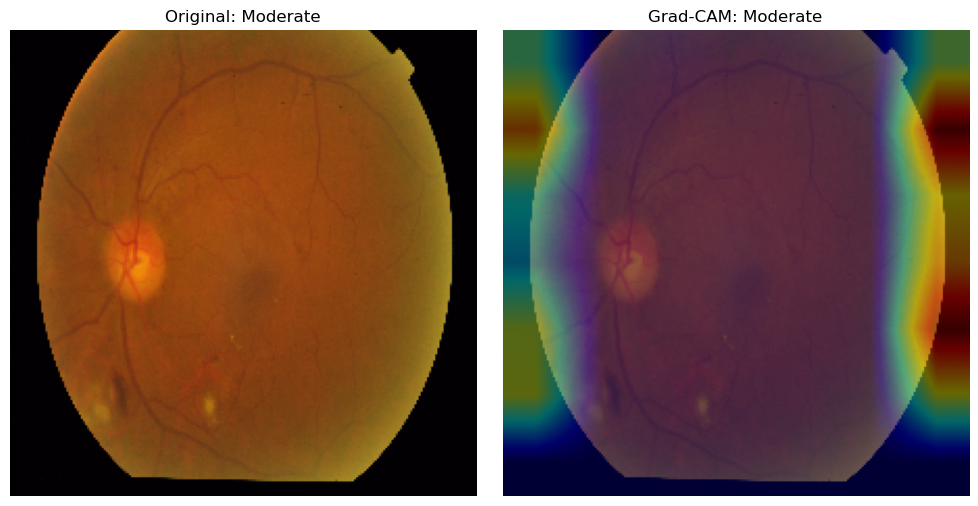

Saved Grad-CAM for Moderate to ConvNeXt_CAM\cam_Moderate.png


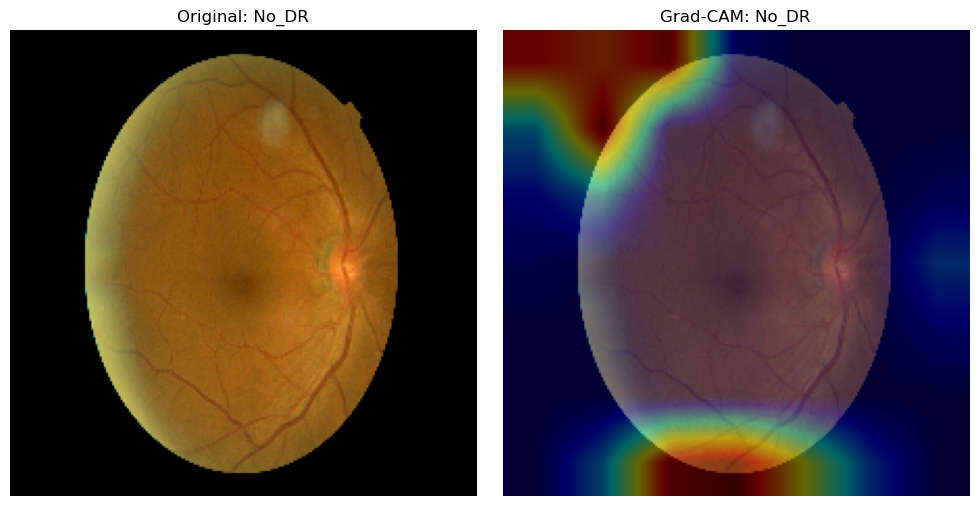

Saved Grad-CAM for No_DR to ConvNeXt_CAM\cam_No_DR.png


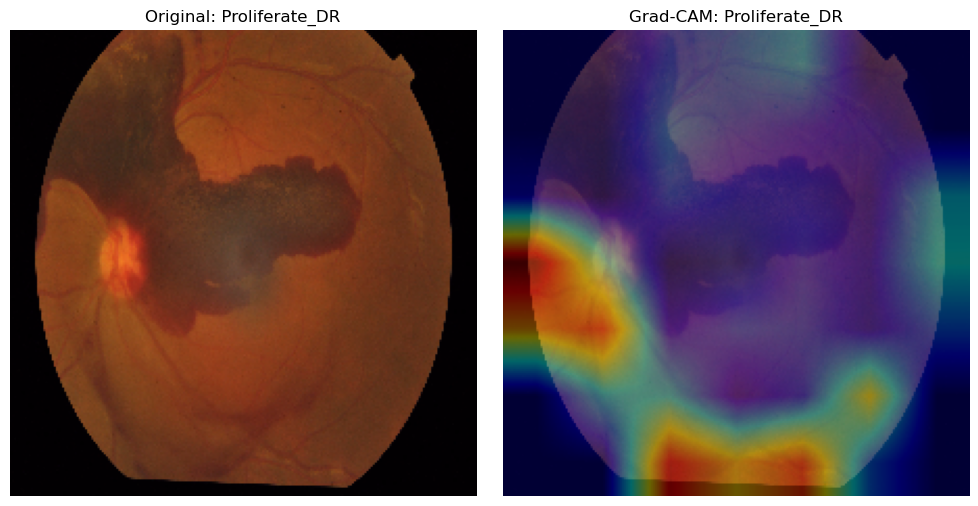

Saved Grad-CAM for Proliferate_DR to ConvNeXt_CAM\cam_Proliferate_DR.png


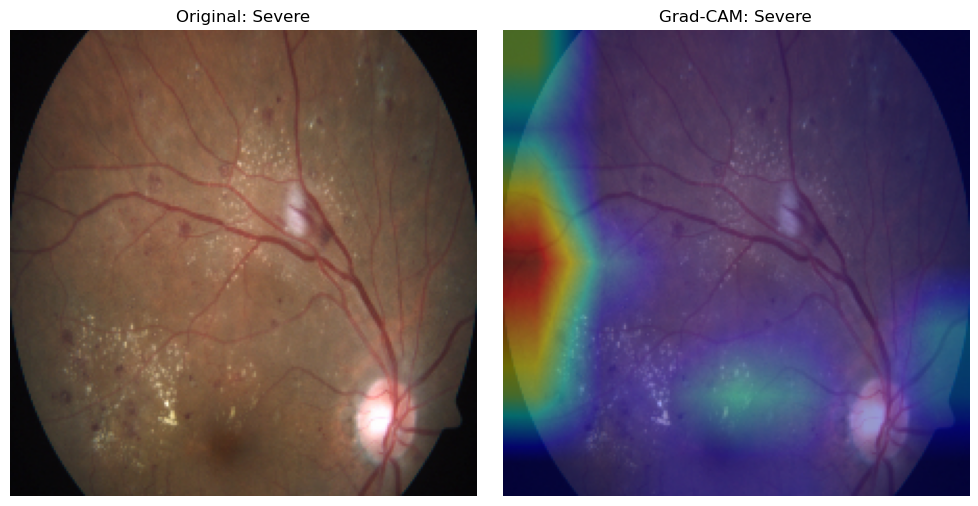

Saved Grad-CAM for Severe to ConvNeXt_CAM\cam_Severe.png


In [7]:
# ============================================================
# ConvNeXt-Tiny with Depthwise Kernel Sweep + GPU Confirmation
# ============================================================

# 1. Necessary Imports
import os
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, Subset, WeightedRandomSampler
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import confusion_matrix, classification_report
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import cv2
from collections import Counter


# 2. Setup and Configuration
def setup():
    """Initializes device, paths, and class names."""
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    
    base_dir = 'colored_images'
    if not os.path.isdir(base_dir):
        raise FileNotFoundError(f"The directory '{base_dir}' was not found. Please ensure it exists.")
        
    class_names = sorted([d for d in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, d))])
    num_classes = len(class_names)
    print(f"Found {num_classes} classes: {class_names}")

    return device, base_dir, class_names, num_classes


# 3. Data Loading and Preprocessing
def class_balanced_weights_from_labels(labels, num_classes, beta=0.9999):
    counts = np.bincount(labels, minlength=num_classes).astype(np.float64)
    effective_num = 1.0 - np.power(beta, counts)
    effective_num = np.where(effective_num > 0, effective_num, 1.0)
    weights = (1.0 - beta) / effective_num
    weights = weights / weights.mean()
    return torch.tensor(weights, dtype=torch.float32)


def get_dataloaders(base_dir, class_names):
    """Creates stratified data loaders with weighted sampling for imbalance."""
    
    data_transforms = {
        'train': transforms.Compose([
            transforms.RandomRotation(15, expand=False),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406],
                                 [0.229, 0.224, 0.225])
        ]),
        'val': transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406],
                                 [0.229, 0.224, 0.225])
        ])
    }

    full_dataset = datasets.ImageFolder(base_dir)
    targets = full_dataset.targets

    sss_train_valtest = StratifiedShuffleSplit(n_splits=1, test_size=0.30, random_state=42)
    train_indices, val_test_indices = next(sss_train_valtest.split(np.zeros(len(targets)), targets))
    val_test_targets = np.array(targets)[val_test_indices]
    sss_val_test = StratifiedShuffleSplit(n_splits=1, test_size=0.50, random_state=42)
    val_sub_indices, test_sub_indices = next(sss_val_test.split(np.zeros(len(val_test_targets)), val_test_targets))
    val_indices = val_test_indices[val_sub_indices]
    test_indices = val_test_indices[test_sub_indices]

    train_dataset = Subset(datasets.ImageFolder(base_dir, transform=data_transforms['train']), train_indices)
    val_dataset = Subset(datasets.ImageFolder(base_dir, transform=data_transforms['val']), val_indices)
    test_dataset = Subset(datasets.ImageFolder(base_dir, transform=data_transforms['val']), test_indices)

    print(f"Dataset split: {len(train_dataset)} train, {len(val_dataset)} validation, {len(test_dataset)} test images.")

    train_labels = [full_dataset.targets[i] for i in train_indices]
    class_counts = Counter(train_labels)
    print(f"Training class distribution: {dict(class_counts)}")

    cb_weights = class_balanced_weights_from_labels(train_labels, num_classes=len(class_names), beta=0.9999)
    sample_weights = [cb_weights[label].item() for label in train_labels]
    sampler = WeightedRandomSampler(weights=sample_weights,
                                    num_samples=len(sample_weights),
                                    replacement=True)

    pin = torch.cuda.is_available()
    dataloaders = {
        'train': DataLoader(train_dataset, batch_size=32, sampler=sampler, num_workers=2, pin_memory=pin),
        'val': DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2, pin_memory=pin),
        'test': DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2, pin_memory=pin),
        'cb_class_weights': cb_weights
    }

    return dataloaders


# 4. Model Training and Evaluation
def _is_depthwise_conv(mod: nn.Module):
    return isinstance(mod, nn.Conv2d) and mod.groups == mod.in_channels and mod.out_channels == mod.in_channels

def _replace_dwconv(module: nn.Module, k: int, dilation: int = 1):
    padding = ((k - 1) // 2) * dilation
    for name, child in module.named_children():
        if _is_depthwise_conv(child):
            new = nn.Conv2d(
                child.in_channels,
                child.out_channels,
                kernel_size=k,
                stride=child.stride,
                padding=padding,
                dilation=dilation,
                groups=child.groups,
                bias=(child.bias is not None),
            )
            nn.init.kaiming_normal_(new.weight, mode='fan_out', nonlinearity='relu')
            if new.bias is not None:
                nn.init.zeros_(new.bias)
            setattr(module, name, new)
        else:
            _replace_dwconv(child, k, dilation)

def build_convnext_tiny_with_dw(num_classes: int, dw_kernel_size: int = 7, dilation: int = 1, pretrained: bool = True):
    weights = models.ConvNeXt_Tiny_Weights.IMAGENET1K_V1 if pretrained else None
    model = models.convnext_tiny(weights=weights)
    _replace_dwconv(model.features, k=dw_kernel_size, dilation=dilation)
    model.classifier[2] = nn.Linear(model.classifier[2].in_features, num_classes)
    return model


def train_model(model, dataloaders, criterion, optimizer, device, num_epochs, class_names):
    """Trains the model with early stopping."""
    best_val_loss = float('inf')
    epochs_no_improve = 0
    patience = 7

    print(f"⚙️ Training on device: {next(model.parameters()).device}")

    for epoch in range(num_epochs):
        print(f'\nEpoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        model.train()
        running_loss = 0.0
        running_corrects = 0
        total_samples = 0

        progress_bar = tqdm(dataloaders['train'], desc="Training")
        for inputs, labels in progress_bar:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)

            preds = outputs.argmax(dim=1)
            running_corrects += (preds == labels).sum().item()
            total_samples += labels.size(0)

            # live GPU usage in tqdm bar
            if torch.cuda.is_available():
                mem_used = torch.cuda.memory_allocated(0)/1024**2
                progress_bar.set_postfix({'loss': f'{loss.item():.4f}', 'GPU_mem_MB': f'{mem_used:.1f}'})

        epoch_loss = running_loss / total_samples
        epoch_train_acc = running_corrects / total_samples

        val_loss, val_acc, _ = evaluate_model(model, dataloaders['val'], criterion, device, class_names)

        print(f'Train Loss: {epoch_loss:.4f} | Train Acc: {epoch_train_acc:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}')

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_no_improve = 0
            torch.save(model.state_dict(), 'best_convnext_model.pth')
            print("Validation loss improved. Saving model.")
        else:
            epochs_no_improve += 1
            print(f"No improvement in validation loss for {epochs_no_improve} epoch(s).")

        if epochs_no_improve >= patience:
            print("Early stopping triggered.")
            break

    print("Training complete.")
    model.load_state_dict(torch.load('best_convnext_model.pth'))
    return model


def evaluate_model(model, dataloader, criterion, device, class_names, is_test=False):
    model.eval()
    running_loss = 0.0
    all_preds, all_labels = [], []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc = np.mean(np.array(all_labels) == np.array(all_preds))
    report_dict = {'true_labels': all_labels, 'pred_labels': all_preds}

    if is_test:
        cm = confusion_matrix(all_labels, all_preds)
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
        plt.title('Confusion Matrix')
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.show()

        per_class_acc = np.divide(np.diag(cm), cm.sum(axis=1).clip(min=1))
        macro_acc = per_class_acc.mean()
        micro_acc = np.trace(cm) / cm.sum().clip(min=1)

        print("\nPer-class accuracy:")
        for idx, name in enumerate(class_names):
            print(f"{name}: {per_class_acc[idx]:.4f}")
        print(f"\nMacro Accuracy: {macro_acc:.4f}")
        print(f"Micro Accuracy (Overall): {micro_acc:.4f}")

    return epoch_loss, epoch_acc, report_dict


# 5. Grad-CAM (unchanged)
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        target_layer.register_forward_hook(self.save_activation)
        target_layer.register_full_backward_hook(self.save_gradient)

    def save_activation(self, module, input, output):
        self.activations = output.detach()

    def save_gradient(self, module, grad_input, grad_output):
        self.gradients = grad_output[0].detach()

    def __call__(self, x, class_idx=None):
        self.model.eval()
        output = self.model(x)
        if class_idx is None:
            class_idx = output.argmax(dim=1).item()
        one_hot = torch.zeros_like(output)
        one_hot[0][class_idx] = 1
        self.model.zero_grad()
        output.backward(gradient=one_hot, retain_graph=True)
        pooled_gradients = torch.mean(self.gradients, dim=[0, 2, 3])
        activ = self.activations.clone()
        for i in range(activ.shape[1]):
            activ[:, i, :, :] *= pooled_gradients[i]
        heatmap = torch.mean(activ, dim=1).squeeze()
        heatmap = torch.clamp(heatmap, min=0)
        heatmap = heatmap / (heatmap.max() + 1e-8)
        return heatmap.cpu().numpy()


def visualize_cam(model, device, base_dir, class_names):
    output_dir = 'ConvNeXt_CAM'
    os.makedirs(output_dir, exist_ok=True)

    target_layer = model.features[-1]
    grad_cam = GradCAM(model, target_layer)

    vis_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])

    for class_name in class_names:
        class_dir = os.path.join(base_dir, class_name)
        img_name = random.choice(os.listdir(class_dir))
        img_path = os.path.join(class_dir, img_name)

        img = Image.open(img_path).convert('RGB')
        input_tensor = vis_transform(img).unsqueeze(0).to(device)

        heatmap = grad_cam(input_tensor)

        img_cv = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)
        heatmap_resized = cv2.resize(heatmap, (img_cv.shape[1], img_cv.shape[0]))
        heatmap_color = cv2.applyColorMap(np.uint8(255 * heatmap_resized), cv2.COLORMAP_JET)
        superimposed_img = cv2.addWeighted(img_cv, 0.6, heatmap_color, 0.4, 0)

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
        ax1.imshow(cv2.cvtColor(img_cv, cv2.COLOR_BGR2RGB))
        ax1.set_title(f'Original: {class_name}')
        ax1.axis('off')

        ax2.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
        ax2.set_title(f'Grad-CAM: {class_name}')
        ax2.axis('off')

        plt.tight_layout()
        save_path = os.path.join(output_dir, f'cam_{class_name}.png')
        plt.savefig(save_path)
        plt.show()
        print(f"Saved Grad-CAM for {class_name} to {save_path}")


# 6. Main Execution Block
if __name__ == '__main__':
    device, base_dir, class_names, num_classes = setup()

    # --- GPU Confirmation ---
    if torch.cuda.is_available():
        print(f"\n✅ CUDA is available. Using GPU: {torch.cuda.get_device_name(0)}")
        print(f"Memory Allocated: {torch.cuda.memory_allocated(0)/1024**2:.2f} MB")
        print(f"Memory Cached: {torch.cuda.memory_reserved(0)/1024**2:.2f} MB")
    else:
        print("\n❌ CUDA not available — running on CPU only!")

    dataloaders = get_dataloaders(base_dir, class_names)

    kernel_sizes = [3, 5, 7, 9, 11]
    results = []

    for k in kernel_sizes:
        print(f"\n===== Testing ConvNeXt-Tiny with DW kernel size = {k} =====")
        model = build_convnext_tiny_with_dw(num_classes=num_classes, dw_kernel_size=k, dilation=1, pretrained=True)
        model = model.to(device)

        weights = dataloaders['cb_class_weights'].to(device)
        criterion = nn.CrossEntropyLoss(weight=weights)
        optimizer = optim.Adam(model.parameters(), lr=1e-4)

        trained_model = train_model(model, dataloaders, criterion, optimizer, device, num_epochs=8, class_names=class_names)

        print("\n--- Validation Snapshot ---")
        val_loss, val_acc, _ = evaluate_model(trained_model, dataloaders['val'], criterion, device, class_names)
        results.append((k, val_acc))

    print("\nKernel size vs Val Acc:")
    for k, acc in results:
        print(f"k={k}: {acc:.4f}")

    best_k = max(results, key=lambda x: x[1])[0]
    print(f"\nBest kernel size by Val Acc: {best_k}")

    model = build_convnext_tiny_with_dw(num_classes=num_classes, dw_kernel_size=best_k, dilation=1, pretrained=True)
    model = model.to(device)

    weights = dataloaders['cb_class_weights'].to(device)
    criterion = nn.CrossEntropyLoss(weight=weights)
    optimizer = optim.Adam(model.parameters(), lr=1e-4)
    trained_model = train_model(model, dataloaders, criterion, optimizer, device, num_epochs=25, class_names=class_names)

    print("\n--- Final Evaluation on Test Set ---")
    test_loss, test_acc, test_report_dict = evaluate_model(trained_model, dataloaders['test'], criterion, device, class_names, is_test=True)
    print(f"\nTest Loss: {test_loss:.4f}")
    print(f"Test Accuracy: {test_acc:.4f}")
    print("\nFinal Test Classification Report:")
    print(classification_report(test_report_dict['true_labels'], test_report_dict['pred_labels'], target_names=class_names, digits=4, zero_division=0))

    print("\n--- Generating Grad-CAM Visualizations ---")
    visualize_cam(trained_model, device, base_dir, class_names)


Using device: cuda
Found 5 classes: ['Mild', 'Moderate', 'No_DR', 'Proliferate_DR', 'Severe']
Dataset split: 2563 train, 549 validation, 550 test images.
Training class distribution: {3: 207, 2: 1263, 1: 699, 4: 135, 0: 259}

===== Testing ConvNeXt-Tiny with DW kernel size = 3 =====

Epoch 1/8
----------


Training: 100%|██████████| 81/81 [01:26<00:00,  1.07s/it, loss=1.0456] 


Train Loss: 1.5045 | Train Acc: 0.2052 | Val Loss: 1.8330 | Val Acc: 0.0911
Validation loss improved. Saving model.

Epoch 2/8
----------


Training: 100%|██████████| 81/81 [01:24<00:00,  1.04s/it, loss=1.4771] 


Train Loss: 1.4021 | Train Acc: 0.2243 | Val Loss: 1.8865 | Val Acc: 0.0656
No improvement in validation loss for 1 epoch(s).

Epoch 3/8
----------


Training: 100%|██████████| 81/81 [01:24<00:00,  1.05s/it, loss=1.3187] 


Train Loss: 1.3600 | Train Acc: 0.2798 | Val Loss: 1.7416 | Val Acc: 0.3333
Validation loss improved. Saving model.

Epoch 4/8
----------


Training: 100%|██████████| 81/81 [01:27<00:00,  1.08s/it, loss=2.3032] 


Train Loss: 1.3187 | Train Acc: 0.3270 | Val Loss: 1.6002 | Val Acc: 0.4372
Validation loss improved. Saving model.

Epoch 5/8
----------


Training: 100%|██████████| 81/81 [01:42<00:00,  1.26s/it, loss=1.2421] 


Train Loss: 1.2984 | Train Acc: 0.3574 | Val Loss: 1.6492 | Val Acc: 0.3151
No improvement in validation loss for 1 epoch(s).

Epoch 6/8
----------


Training: 100%|██████████| 81/81 [01:56<00:00,  1.44s/it, loss=1.6987] 


Train Loss: 1.2800 | Train Acc: 0.3890 | Val Loss: 1.5779 | Val Acc: 0.3370
Validation loss improved. Saving model.

Epoch 7/8
----------


Training: 100%|██████████| 81/81 [01:57<00:00,  1.45s/it, loss=0.7758] 


Train Loss: 1.2922 | Train Acc: 0.3621 | Val Loss: 1.7475 | Val Acc: 0.3260
No improvement in validation loss for 1 epoch(s).

Epoch 8/8
----------


Training: 100%|██████████| 81/81 [01:51<00:00,  1.37s/it, loss=0.5567] 


Train Loss: 1.2323 | Train Acc: 0.4124 | Val Loss: 1.6345 | Val Acc: 0.4863
No improvement in validation loss for 2 epoch(s).
Training complete.


C:\Users\Sahil\AppData\Local\Temp\ipykernel_37704\1652008282.py:234: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_convnext_model.pth'


--- Validation Snapshot ---

===== Testing ConvNeXt-Tiny with DW kernel size = 5 =====

Epoch 1/8
----------


Training: 100%|██████████| 81/81 [01:46<00:00,  1.31s/it, loss=1.3311] 


Train Loss: 1.4863 | Train Acc: 0.2107 | Val Loss: 1.9950 | Val Acc: 0.0893
Validation loss improved. Saving model.

Epoch 2/8
----------


Training: 100%|██████████| 81/81 [01:30<00:00,  1.12s/it, loss=1.6468] 


Train Loss: 1.3888 | Train Acc: 0.2450 | Val Loss: 1.8472 | Val Acc: 0.0710
Validation loss improved. Saving model.

Epoch 3/8
----------


Training: 100%|██████████| 81/81 [01:29<00:00,  1.10s/it, loss=1.1943] 


Train Loss: 1.3508 | Train Acc: 0.2794 | Val Loss: 1.6995 | Val Acc: 0.2222
Validation loss improved. Saving model.

Epoch 4/8
----------


Training: 100%|██████████| 81/81 [01:56<00:00,  1.43s/it, loss=1.4790] 


Train Loss: 1.2704 | Train Acc: 0.3554 | Val Loss: 1.5746 | Val Acc: 0.3497
Validation loss improved. Saving model.

Epoch 5/8
----------


Training: 100%|██████████| 81/81 [01:40<00:00,  1.24s/it, loss=1.3450] 


Train Loss: 1.2628 | Train Acc: 0.3652 | Val Loss: 1.6923 | Val Acc: 0.1803
No improvement in validation loss for 1 epoch(s).

Epoch 6/8
----------


Training: 100%|██████████| 81/81 [01:38<00:00,  1.22s/it, loss=1.1519] 


Train Loss: 1.2522 | Train Acc: 0.3968 | Val Loss: 1.6267 | Val Acc: 0.4026
No improvement in validation loss for 2 epoch(s).

Epoch 7/8
----------


Training: 100%|██████████| 81/81 [01:33<00:00,  1.16s/it, loss=1.0184] 


Train Loss: 1.2345 | Train Acc: 0.4023 | Val Loss: 1.6237 | Val Acc: 0.4718
No improvement in validation loss for 3 epoch(s).

Epoch 8/8
----------


Training: 100%|██████████| 81/81 [01:21<00:00,  1.00s/it, loss=2.2860] 


Train Loss: 1.2487 | Train Acc: 0.4108 | Val Loss: 1.5783 | Val Acc: 0.4681
No improvement in validation loss for 4 epoch(s).
Training complete.

--- Validation Snapshot ---

===== Testing ConvNeXt-Tiny with DW kernel size = 7 =====

Epoch 1/8
----------


Training: 100%|██████████| 81/81 [01:38<00:00,  1.21s/it, loss=1.3058] 


Train Loss: 1.5041 | Train Acc: 0.2072 | Val Loss: 1.9939 | Val Acc: 0.1056
Validation loss improved. Saving model.

Epoch 2/8
----------


Training: 100%|██████████| 81/81 [01:50<00:00,  1.37s/it, loss=2.8138] 


Train Loss: 1.4274 | Train Acc: 0.2310 | Val Loss: 1.8850 | Val Acc: 0.0583
Validation loss improved. Saving model.

Epoch 3/8
----------


Training: 100%|██████████| 81/81 [02:28<00:00,  1.84s/it, loss=1.4176] 


Train Loss: 1.4182 | Train Acc: 0.2193 | Val Loss: 1.9109 | Val Acc: 0.1038
No improvement in validation loss for 1 epoch(s).

Epoch 4/8
----------


Training: 100%|██████████| 81/81 [02:07<00:00,  1.57s/it, loss=1.6404] 


Train Loss: 1.3717 | Train Acc: 0.2630 | Val Loss: 1.8368 | Val Acc: 0.1330
Validation loss improved. Saving model.

Epoch 5/8
----------


Training: 100%|██████████| 81/81 [02:02<00:00,  1.52s/it, loss=1.2352] 


Train Loss: 1.3114 | Train Acc: 0.3039 | Val Loss: 1.8408 | Val Acc: 0.1494
No improvement in validation loss for 1 epoch(s).

Epoch 6/8
----------


Training: 100%|██████████| 81/81 [01:50<00:00,  1.37s/it, loss=1.3370] 


Train Loss: 1.2815 | Train Acc: 0.3449 | Val Loss: 1.6255 | Val Acc: 0.4244
Validation loss improved. Saving model.

Epoch 7/8
----------


Training: 100%|██████████| 81/81 [01:51<00:00,  1.38s/it, loss=1.0353] 


Train Loss: 1.2621 | Train Acc: 0.4054 | Val Loss: 1.7683 | Val Acc: 0.2896
No improvement in validation loss for 1 epoch(s).

Epoch 8/8
----------


Training: 100%|██████████| 81/81 [01:59<00:00,  1.47s/it, loss=1.6449] 


Train Loss: 1.2608 | Train Acc: 0.3882 | Val Loss: 1.6706 | Val Acc: 0.2514
No improvement in validation loss for 2 epoch(s).
Training complete.

--- Validation Snapshot ---

===== Testing ConvNeXt-Tiny with DW kernel size = 9 =====

Epoch 1/8
----------


Training: 100%|██████████| 81/81 [02:25<00:00,  1.79s/it, loss=1.8532] 


Train Loss: 1.5147 | Train Acc: 0.2009 | Val Loss: 1.9180 | Val Acc: 0.0765
Validation loss improved. Saving model.

Epoch 2/8
----------


Training: 100%|██████████| 81/81 [02:53<00:00,  2.15s/it, loss=1.2126] 


Train Loss: 1.3944 | Train Acc: 0.2318 | Val Loss: 1.8395 | Val Acc: 0.0510
Validation loss improved. Saving model.

Epoch 3/8
----------


Training: 100%|██████████| 81/81 [02:44<00:00,  2.03s/it, loss=1.8695] 


Train Loss: 1.3218 | Train Acc: 0.2762 | Val Loss: 1.6960 | Val Acc: 0.3880
Validation loss improved. Saving model.

Epoch 4/8
----------


Training: 100%|██████████| 81/81 [02:29<00:00,  1.84s/it, loss=1.8413] 


Train Loss: 1.3104 | Train Acc: 0.3426 | Val Loss: 1.6167 | Val Acc: 0.3352
Validation loss improved. Saving model.

Epoch 5/8
----------


Training: 100%|██████████| 81/81 [02:29<00:00,  1.84s/it, loss=1.0917] 


Train Loss: 1.2804 | Train Acc: 0.3773 | Val Loss: 1.7919 | Val Acc: 0.2514
No improvement in validation loss for 1 epoch(s).

Epoch 6/8
----------


Training: 100%|██████████| 81/81 [02:31<00:00,  1.87s/it, loss=2.2727] 


Train Loss: 1.2821 | Train Acc: 0.3543 | Val Loss: 1.5284 | Val Acc: 0.4663
Validation loss improved. Saving model.

Epoch 7/8
----------


Training: 100%|██████████| 81/81 [02:19<00:00,  1.72s/it, loss=0.8690] 


Train Loss: 1.2562 | Train Acc: 0.4046 | Val Loss: 1.6513 | Val Acc: 0.4226
No improvement in validation loss for 1 epoch(s).

Epoch 8/8
----------


Training: 100%|██████████| 81/81 [01:45<00:00,  1.30s/it, loss=0.8154]


Train Loss: 1.2333 | Train Acc: 0.4276 | Val Loss: 1.6111 | Val Acc: 0.4007
No improvement in validation loss for 2 epoch(s).
Training complete.

--- Validation Snapshot ---

===== Testing ConvNeXt-Tiny with DW kernel size = 11 =====

Epoch 1/8
----------


Training: 100%|██████████| 81/81 [02:15<00:00,  1.68s/it, loss=1.9288]


Train Loss: 1.4768 | Train Acc: 0.2150 | Val Loss: 1.9380 | Val Acc: 0.1020
Validation loss improved. Saving model.

Epoch 2/8
----------


Training: 100%|██████████| 81/81 [03:03<00:00,  2.26s/it, loss=1.5918] 


Train Loss: 1.4017 | Train Acc: 0.2224 | Val Loss: 1.8588 | Val Acc: 0.0893
Validation loss improved. Saving model.

Epoch 3/8
----------


Training: 100%|██████████| 81/81 [03:09<00:00,  2.34s/it, loss=1.3147] 


Train Loss: 1.3742 | Train Acc: 0.2321 | Val Loss: 1.9385 | Val Acc: 0.1056
No improvement in validation loss for 1 epoch(s).

Epoch 4/8
----------


Training: 100%|██████████| 81/81 [11:01<00:00,  8.17s/it, loss=1.6163]  


Train Loss: 1.3871 | Train Acc: 0.2411 | Val Loss: 1.7869 | Val Acc: 0.1603
Validation loss improved. Saving model.

Epoch 5/8
----------


Training: 100%|██████████| 81/81 [19:25<00:00, 14.39s/it, loss=0.9119]  


Train Loss: 1.2823 | Train Acc: 0.3219 | Val Loss: 1.7592 | Val Acc: 0.3752
Validation loss improved. Saving model.

Epoch 6/8
----------


Training: 100%|██████████| 81/81 [14:37<00:00, 10.83s/it, loss=1.1139]  


Train Loss: 1.3071 | Train Acc: 0.3664 | Val Loss: 1.6300 | Val Acc: 0.3297
Validation loss improved. Saving model.

Epoch 7/8
----------


Training: 100%|██████████| 81/81 [13:46<00:00, 10.20s/it, loss=1.0536] 


Train Loss: 1.2665 | Train Acc: 0.3808 | Val Loss: 1.6528 | Val Acc: 0.3807
No improvement in validation loss for 1 epoch(s).

Epoch 8/8
----------


Training: 100%|██████████| 81/81 [13:40<00:00, 10.13s/it, loss=1.7473] 


Train Loss: 1.2600 | Train Acc: 0.3878 | Val Loss: 1.6458 | Val Acc: 0.4390
No improvement in validation loss for 2 epoch(s).
Training complete.

--- Validation Snapshot ---

Kernel size vs Val Acc:
k=3: 0.3370
k=5: 0.3497
k=7: 0.4244
k=9: 0.4663
k=11: 0.3297

Best kernel size by Val Acc: 9

Epoch 1/25
----------


Training: 100%|██████████| 81/81 [11:04<00:00,  8.20s/it, loss=2.3096] 


Train Loss: 1.5116 | Train Acc: 0.1978 | Val Loss: 1.9675 | Val Acc: 0.0528
Validation loss improved. Saving model.

Epoch 2/25
----------


Training: 100%|██████████| 81/81 [09:38<00:00,  7.14s/it, loss=1.3775] 


Train Loss: 1.4244 | Train Acc: 0.2056 | Val Loss: 1.9107 | Val Acc: 0.0510
Validation loss improved. Saving model.

Epoch 3/25
----------


Training: 100%|██████████| 81/81 [09:08<00:00,  6.77s/it, loss=2.4412] 


Train Loss: 1.3920 | Train Acc: 0.2282 | Val Loss: 1.7172 | Val Acc: 0.0929
Validation loss improved. Saving model.

Epoch 4/25
----------


Training: 100%|██████████| 81/81 [10:12<00:00,  7.56s/it, loss=1.7296] 


Train Loss: 1.3230 | Train Acc: 0.2977 | Val Loss: 1.7172 | Val Acc: 0.2459
No improvement in validation loss for 1 epoch(s).

Epoch 5/25
----------


Training: 100%|██████████| 81/81 [08:59<00:00,  6.66s/it, loss=1.6890] 


Train Loss: 1.2890 | Train Acc: 0.3422 | Val Loss: 1.6976 | Val Acc: 0.2641
Validation loss improved. Saving model.

Epoch 6/25
----------


Training: 100%|██████████| 81/81 [08:50<00:00,  6.55s/it, loss=0.7846] 


Train Loss: 1.2564 | Train Acc: 0.3769 | Val Loss: 1.7379 | Val Acc: 0.4135
No improvement in validation loss for 1 epoch(s).

Epoch 7/25
----------


Training: 100%|██████████| 81/81 [10:15<00:00,  7.59s/it, loss=2.2803] 


Train Loss: 1.2672 | Train Acc: 0.3804 | Val Loss: 1.5731 | Val Acc: 0.4663
Validation loss improved. Saving model.

Epoch 8/25
----------


Training: 100%|██████████| 81/81 [09:38<00:00,  7.14s/it, loss=0.9208] 


Train Loss: 1.2432 | Train Acc: 0.4069 | Val Loss: 1.6572 | Val Acc: 0.3643
No improvement in validation loss for 1 epoch(s).

Epoch 9/25
----------


Training: 100%|██████████| 81/81 [08:02<00:00,  5.96s/it, loss=0.9055] 


Train Loss: 1.2498 | Train Acc: 0.3828 | Val Loss: 1.6096 | Val Acc: 0.3260
No improvement in validation loss for 2 epoch(s).

Epoch 10/25
----------


Training: 100%|██████████| 81/81 [02:44<00:00,  2.03s/it, loss=1.3624] 


Train Loss: 1.2260 | Train Acc: 0.4421 | Val Loss: 1.6066 | Val Acc: 0.4135
No improvement in validation loss for 3 epoch(s).

Epoch 11/25
----------


Training: 100%|██████████| 81/81 [02:09<00:00,  1.60s/it, loss=0.8697]


Train Loss: 1.2289 | Train Acc: 0.4116 | Val Loss: 1.5991 | Val Acc: 0.4499
No improvement in validation loss for 4 epoch(s).

Epoch 12/25
----------


Training: 100%|██████████| 81/81 [02:02<00:00,  1.52s/it, loss=1.0211]


Train Loss: 1.2120 | Train Acc: 0.4311 | Val Loss: 1.5781 | Val Acc: 0.4809
No improvement in validation loss for 5 epoch(s).
Early stopping triggered.
Training complete.

--- Final Evaluation on Test Set ---


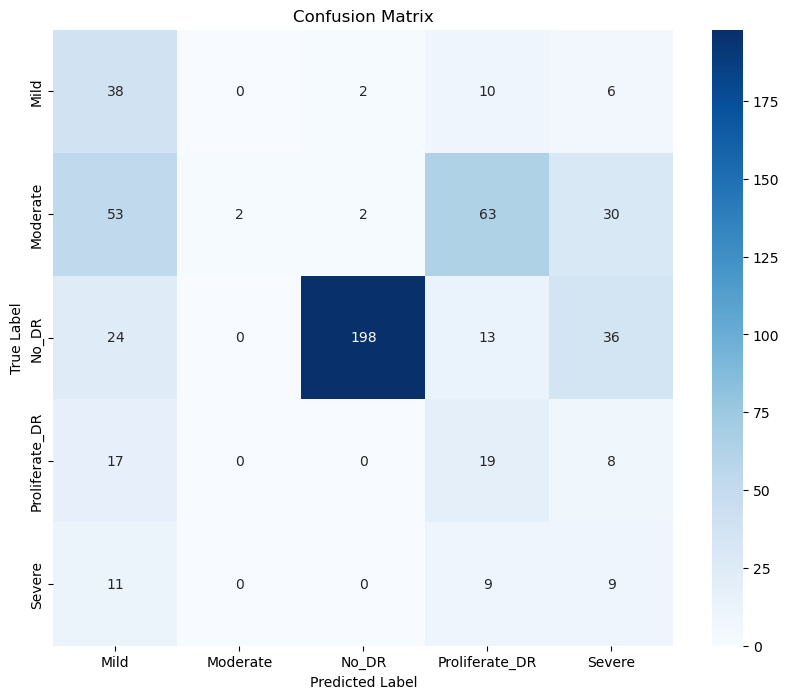


Per-class accuracy:
Mild: 0.6786
Moderate: 0.0133
No_DR: 0.7306
Proliferate_DR: 0.4318
Severe: 0.3103

Macro Accuracy: 0.4329
Micro Accuracy (Overall): 0.4836

Test Loss: 1.5788
Test Accuracy: 0.4836

Final Test Classification Report:
                precision    recall  f1-score   support

          Mild     0.2657    0.6786    0.3819        56
      Moderate     1.0000    0.0133    0.0263       150
         No_DR     0.9802    0.7306    0.8372       271
Proliferate_DR     0.1667    0.4318    0.2405        44
        Severe     0.1011    0.3103    0.1525        29

      accuracy                         0.4836       550
     macro avg     0.5027    0.4329    0.3277       550
  weighted avg     0.8014    0.4836    0.4859       550


--- Generating Grad-CAM Visualizations ---


TypeError: GradCAM() takes no arguments

In [9]:
# 1. Necessary Imports
import os
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, Subset, WeightedRandomSampler
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import confusion_matrix, classification_report
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import cv2
from collections import Counter

# 2. Setup and Configuration
def setup():
    """Initializes device, paths, and class names."""
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    
    base_dir = 'colored_images'
    if not os.path.isdir(base_dir):
        raise FileNotFoundError(f"The directory '{base_dir}' was not found. Please ensure it exists.")
        
    class_names = sorted([d for d in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, d))])
    num_classes = len(class_names)
    print(f"Found {num_classes} classes: {class_names}")

    return device, base_dir, class_names, num_classes


# 3. Data Loading and Preprocessing

# Helper: Class-Balanced weights (effective number of samples)
def class_balanced_weights_from_labels(labels, num_classes, beta=0.9999):
    counts = np.bincount(labels, minlength=num_classes).astype(np.float64)
    effective_num = 1.0 - np.power(beta, counts)
    effective_num = np.where(effective_num > 0, effective_num, 1.0)
    weights = (1.0 - beta) / effective_num
    weights = weights / weights.mean()
    return torch.tensor(weights, dtype=torch.float32)

def get_dataloaders(base_dir, class_names):
    """Creates stratified data loaders with weighted sampling for imbalance."""
    
    # Training augmentation only; no aug on val/test; images are already 224x224
    data_transforms = {
        'train': transforms.Compose([
            transforms.RandomRotation(15, expand=False),  # keeps 224x224
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406],
                                 [0.229, 0.224, 0.225])
        ]),
        'val': transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406],
                                 [0.229, 0.224, 0.225])
        ])
    }

    # Load full dataset
    full_dataset = datasets.ImageFolder(base_dir)
    targets = full_dataset.targets

    # Stratified split (70/15/15)
    sss_train_valtest = StratifiedShuffleSplit(n_splits=1, test_size=0.30, random_state=42)
    train_indices, val_test_indices = next(sss_train_valtest.split(np.zeros(len(targets)), targets))
    val_test_targets = np.array(targets)[val_test_indices]
    sss_val_test = StratifiedShuffleSplit(n_splits=1, test_size=0.50, random_state=42)
    val_sub_indices, test_sub_indices = next(sss_val_test.split(np.zeros(len(val_test_targets)), val_test_targets))
    val_indices = val_test_indices[val_sub_indices]
    test_indices = val_test_indices[test_sub_indices]

    # Create subsets
    train_dataset = Subset(datasets.ImageFolder(base_dir, transform=data_transforms['train']), train_indices)
    val_dataset = Subset(datasets.ImageFolder(base_dir, transform=data_transforms['val']), val_indices)
    test_dataset = Subset(datasets.ImageFolder(base_dir, transform=data_transforms['val']), test_indices)

    print(f"Dataset split: {len(train_dataset)} train, {len(val_dataset)} validation, {len(test_dataset)} test images.")

    # ---- HANDLE CLASS IMBALANCE ----
    train_labels = [full_dataset.targets[i] for i in train_indices]
    class_counts = Counter(train_labels)
    print(f"Training class distribution: {dict(class_counts)}")

    cb_weights = class_balanced_weights_from_labels(train_labels, num_classes=len(class_names), beta=0.9999)
    sample_weights = [cb_weights[label].item() for label in train_labels]
    sampler = WeightedRandomSampler(weights=sample_weights,
                                    num_samples=len(sample_weights),
                                    replacement=True)

    # Create dataloaders (pin_memory only if CUDA)
    pin = torch.cuda.is_available()
    dataloaders = {
        'train': DataLoader(train_dataset, batch_size=32, sampler=sampler, num_workers=4, pin_memory=pin),
        'val': DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4, pin_memory=pin),
        'test': DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4, pin_memory=pin),
        'cb_class_weights': cb_weights
    }

    return dataloaders


# 4. Model Training and Evaluation

# Depthwise kernel-size replacement to try different convolutions
def _is_depthwise_conv(mod: nn.Module):
    return isinstance(mod, nn.Conv2d) and mod.groups == mod.in_channels and mod.out_channels == mod.in_channels

def _replace_dwconv(module: nn.Module, k: int, dilation: int = 1):
    padding = ((k - 1) // 2) * dilation
    for name, child in module.named_children():
        if _is_depthwise_conv(child):
            new = nn.Conv2d(
                child.in_channels,
                child.out_channels,
                kernel_size=k,
                stride=child.stride,
                padding=padding,
                dilation=dilation,
                groups=child.groups,
                bias=(child.bias is not None),
            )
            nn.init.kaiming_normal_(new.weight, mode='fan_out', nonlinearity='relu')
            if new.bias is not None:
                nn.init.zeros_(new.bias)
            setattr(module, name, new)
        else:
            _replace_dwconv(child, k, dilation)

def _attach_visual_autoencoder(model: nn.Module):
    """Attach a lightweight decoder and a forward hook to capture the last spatial feature map."""
    in_ch = model.classifier[2].in_features  # 768 for ConvNeXt-Tiny @ 224
    decoder = nn.Sequential(
        nn.Conv2d(in_ch, 256, 3, padding=1), nn.ReLU(inplace=True),
        nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),
        nn.Conv2d(256, 128, 3, padding=1), nn.ReLU(inplace=True),
        nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),
        nn.Conv2d(128, 64, 3, padding=1), nn.ReLU(inplace=True),
        nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),
        nn.Conv2d(64, 32, 3, padding=1), nn.ReLU(inplace=True),
        nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),
        nn.Conv2d(32, 16, 3, padding=1), nn.ReLU(inplace=True),
        nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),
        nn.Conv2d(16, 3, 1)
    )
    model.recon_decoder = decoder
    model._ae_feats = None
    def save_feats(module, inp, out):
        model._ae_feats = out  # keep graph for joint training
    # hook the last stage output (spatial map, ~7x7)
    model._ae_hook = model.features[-1].register_forward_hook(save_feats)
    return model

def build_convnext_tiny_with_dw(num_classes: int, dw_kernel_size: int = 7, dilation: int = 1, pretrained: bool = True, use_autoencoder: bool = True):
    weights = models.ConvNeXt_Tiny_Weights.IMAGENET1K_V1 if pretrained else None
    model = models.convnext_tiny(weights=weights)
    _replace_dwconv(model.features, k=dw_kernel_size, dilation=dilation)
    model.classifier[2] = nn.Linear(model.classifier[2].in_features, num_classes)
    if use_autoencoder:
        _attach_visual_autoencoder(model)
    return model

def train_model(model, dataloaders, criterion, optimizer, device, num_epochs, class_names):
    """Trains the model with early stopping."""
    best_val_loss = float('inf')
    epochs_no_improve = 0
    patience = 5
    ae_lambda = 0.1  # weight for reconstruction auxiliary loss

    recon_loss_fn = nn.MSELoss()

    for epoch in range(num_epochs):
        print(f'\nEpoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        model.train()
        running_loss = 0.0
        running_corrects = 0
        total_samples = 0

        progress_bar = tqdm(dataloaders['train'], desc="Training")
        for inputs, labels in progress_bar:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)

            # primary loss: label-smoothed CE (already configured in criterion)
            loss = criterion(outputs, labels)

            # auxiliary: visual autoencoder reconstruction loss
            if hasattr(model, 'recon_decoder') and getattr(model, '_ae_feats', None) is not None:
                recon = model.recon_decoder(model._ae_feats)
                loss_recon = recon_loss_fn(recon, inputs)
                loss = loss + ae_lambda * loss_recon

            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            preds = outputs.argmax(dim=1)
            running_corrects += (preds == labels).sum().item()
            total_samples += labels.size(0)

            progress_bar.set_postfix({'loss': f'{loss.item():.4f}'})

        epoch_loss = running_loss / total_samples
        epoch_train_acc = running_corrects / total_samples

        val_loss, val_acc, _ = evaluate_model(model, dataloaders['val'], criterion, device, class_names)

        print(f'Train Loss: {epoch_loss:.4f} | Train Acc: {epoch_train_acc:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}')

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_no_improve = 0
            torch.save(model.state_dict(), 'best_convnext_model.pth')
            print("Validation loss improved. Saving model.")
        else:
            epochs_no_improve += 1
            print(f"No improvement in validation loss for {epochs_no_improve} epoch(s).")

        if epochs_no_improve >= patience:
            print("Early stopping triggered.")
            break

    print("Training complete.")
    model.load_state_dict(torch.load('best_convnext_model.pth'))
    return model


def evaluate_model(model, dataloader, criterion, device, class_names, is_test=False):
    model.eval()
    running_loss = 0.0
    all_preds, all_labels = [], []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc = np.mean(np.array(all_labels) == np.array(all_preds))
    report_dict = {'true_labels': all_labels, 'pred_labels': all_preds}

    if is_test:
        cm = confusion_matrix(all_labels, all_preds)
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
        plt.title('Confusion Matrix')
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.show()

        # Extended metrics: per-class accuracy + macro/micro accuracy
        per_class_acc = np.divide(np.diag(cm), cm.sum(axis=1).clip(min=1))
        macro_acc = per_class_acc.mean()
        micro_acc = np.trace(cm) / cm.sum().clip(min=1)

        print("\nPer-class accuracy:")
        for idx, name in enumerate(class_names):
            print(f"{name}: {per_class_acc[idx]:.4f}")
        print(f"\nMacro Accuracy: {macro_acc:.4f}")
        print(f"Micro Accuracy (Overall): {micro_acc:.4f}")

    return epoch_loss, epoch_acc, report_dict


# 5. Grad-CAM (same as before)
class GradCAM:
    def _init_(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        target_layer.register_forward_hook(self.save_activation)
        target_layer.register_full_backward_hook(self.save_gradient)

    def save_activation(self, module, input, output):
        self.activations = output.detach()

    def save_gradient(self, module, grad_input, grad_output):
        self.gradients = grad_output[0].detach()

    def _call_(self, x, class_idx=None):
        self.model.eval()
        output = self.model(x)
        if class_idx is None:
            class_idx = output.argmax(dim=1).item()
        one_hot = torch.zeros_like(output)
        one_hot[0][class_idx] = 1
        self.model.zero_grad()
        output.backward(gradient=one_hot, retain_graph=True)
        pooled_gradients = torch.mean(self.gradients, dim=[0, 2, 3])
        activ = self.activations.clone()
        for i in range(activ.shape[1]):
            activ[:, i, :, :] *= pooled_gradients[i]
        heatmap = torch.mean(activ, dim=1).squeeze()
        heatmap = torch.clamp(heatmap, min=0)
        heatmap = heatmap / (heatmap.max() + 1e-8)
        return heatmap.cpu().numpy()


def visualize_cam(model, device, base_dir, class_names):
    output_dir = 'ConvNeXt_CAM'
    os.makedirs(output_dir, exist_ok=True)

    target_layer = model.features[-1]  # for ConvNeXt
    grad_cam = GradCAM(model, target_layer)

    vis_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])

    for class_name in class_names:
        class_dir = os.path.join(base_dir, class_name)
        img_name = random.choice(os.listdir(class_dir))
        img_path = os.path.join(class_dir, img_name)

        img = Image.open(img_path).convert('RGB')
        input_tensor = vis_transform(img).unsqueeze(0).to(device)

        heatmap = grad_cam(input_tensor)

        img_cv = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)  # assumes 224x224 inputs
        heatmap_resized = cv2.resize(heatmap, (img_cv.shape[1], img_cv.shape[0]))
        heatmap_color = cv2.applyColorMap(np.uint8(255 * heatmap_resized), cv2.COLORMAP_JET)
        superimposed_img = cv2.addWeighted(img_cv, 0.6, heatmap_color, 0.4, 0)

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
        ax1.imshow(cv2.cvtColor(img_cv, cv2.COLOR_BGR2RGB))
        ax1.set_title(f'Original: {class_name}')
        ax1.axis('off')

        ax2.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
        ax2.set_title(f'Grad-CAM: {class_name}')
        ax2.axis('off')

        plt.tight_layout()
        save_path = os.path.join(output_dir, f'cam_{class_name}.png')
        plt.savefig(save_path)
        plt.show()
        print(f"Saved Grad-CAM for {class_name} to {save_path}")


# 6. Main Execution Block
if __name__ == '__main__':
    device, base_dir, class_names, num_classes = setup()
    dataloaders = get_dataloaders(base_dir, class_names)

    # Load ConvNeXt-Tiny with different DW kernels and sweep (with visual autoencoder + label smoothing)
    kernel_sizes = [3, 5, 7, 9, 11]
    results = []

    for k in kernel_sizes:
        print(f"\n===== Testing ConvNeXt-Tiny with DW kernel size = {k} =====")
        model = build_convnext_tiny_with_dw(num_classes=num_classes, dw_kernel_size=k, dilation=1, pretrained=True, use_autoencoder=True)
        model = model.to(device)

        weights = dataloaders['cb_class_weights'].to(device)
        criterion = nn.CrossEntropyLoss(weight=weights, label_smoothing=0.1)  # label smoothing enabled
        optimizer = optim.Adam(model.parameters(), lr=1e-4)

        trained_model = train_model(model, dataloaders, criterion, optimizer, device, num_epochs=8, class_names=class_names)

        print("\n--- Validation Snapshot ---")
        val_loss, val_acc, _ = evaluate_model(trained_model, dataloaders['val'], criterion, device, class_names, is_test=False)
        results.append((k, val_acc))

    print("\nKernel size vs Val Acc:")
    for k, acc in results:
        print(f"k={k}: {acc:.4f}")

    best_k = max(results, key=lambda x: x[1])[0]
    print(f"\nBest kernel size by Val Acc: {best_k}")
    model = build_convnext_tiny_with_dw(num_classes=num_classes, dw_kernel_size=best_k, dilation=1, pretrained=True, use_autoencoder=True)
    model = model.to(device)

    weights = dataloaders['cb_class_weights'].to(device)
    criterion = nn.CrossEntropyLoss(weight=weights, label_smoothing=0.1)  # label smoothing enabled
    optimizer = optim.Adam(model.parameters(), lr=1e-4)
    trained_model = train_model(model, dataloaders, criterion, optimizer, device, num_epochs=25, class_names=class_names)

    print("\n--- Final Evaluation on Test Set ---")
    test_loss, test_acc, test_report_dict = evaluate_model(trained_model, dataloaders['test'], criterion, device, class_names, is_test=True)
    print(f"\nTest Loss: {test_loss:.4f}")
    print(f"Test Accuracy: {test_acc:.4f}")
    print("\nFinal Test Classification Report:")
    print(classification_report(test_report_dict['true_labels'], test_report_dict['pred_labels'], target_names=class_names, digits=4, zero_division=0))

    print("\n--- Generating Grad-CAM Visualizations ---")
    visualize_cam(trained_model, device, base_dir, class_names)